In [3]:
! pip install transformers==3.5.1 -qq >> /dev/null

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import gdown
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from io import StringIO
from textwrap import wrap
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score,classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import torch
import transformers
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

tqdm.pandas()

ImportError: ignored

In [ ]:
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 128
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
! rm -r *
gdown.download(url='https://drive.google.com/uc?id=1i__vau9jJdejh1T87U34BqZjq4j8I7sC', output='Data.zip', quiet=True)
gdown.download(url='https://drive.google.com/uc?id=123C0ind9WHa3Ep7VEWpGTItFuEHuygFR', output='added_data.xlsx', quiet=True)
gdown.download(url='https://drive.google.com/uc?id=1N46G6pbPIPay4FpBxGio8Tgd6dmTTuJD', output='labeled_data_1.csv', quiet=True)
gdown.download(url='https://drive.google.com/uc?id=1EEEbTTsvv_JwOELTeQmIceGgPNwqwv8Z', output='defined_lexicon_1.csv', quiet=True)
! unzip -q Data.zip
! rm Data.zip

In [ ]:
df1 = pd.read_excel('added_data.xlsx')
df1.drop_duplicates(keep=False, inplace=True)
df1.dropna(axis=0, inplace=True)
classes = {'NOT': 0, 'ABUSIVE': 1}
df1['class'] = df1['class'].map(classes)
df1.head()

In [ ]:
df2 = pd.read_csv('labeled_data_1.csv', encoding='latin1')
# remove index column (not informative)
df2.drop(['index'], axis=1, inplace=True)
# # remove duplicate rows if any, keep one out of the duplicates
df2.drop_duplicates(keep=False, inplace=True)
# remove blank rows if any.
df2.dropna(axis=0, inplace=True)
# rename class text values  to numeric value
classes = {'NOT': 0, 'ABUSIVE': 1}
df2['class'] = df2['class'].map(classes)
df2.head()

In [ ]:
#concatenate the two dfs
df = pd.concat([df1, df2])

# shuffle df
df = shuffle(df)

In [ ]:
FLAGS = re.MULTILINE | re.DOTALL
stopwords = ['na', 'ya', 'ni', 'au', 'wewe']

def clean_text(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>") # remove urls
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "") # removed <user>
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "") #removed <number>
    return text.lower()

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese characters
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"    
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocess_text(text):
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    # remove single character
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    # removing multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

def pre_process_text(text):
    text = str(text)
    text = clean_text(text)
    text = remove_emoji(text)
    text = preprocess_text(text)
    # remove stopwords
    # text = ' '.join([word for word in text.split() if word not in stopwords])
    return text.strip()

In [ ]:
df.tweet = df.tweet.progress_apply(pre_process_text)
df.head()

In [ ]:
RANDOM_SEED=123

df_train, tra_val  = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_valid, df_test  = train_test_split(tra_val, test_size=0.4, random_state=RANDOM_SEED)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# Load Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []
for txt in df.tweet:
  tokens = tokenizer.encode(str(txt), max_length=512, truncation=True)
  token_lens.append(len(tokens))

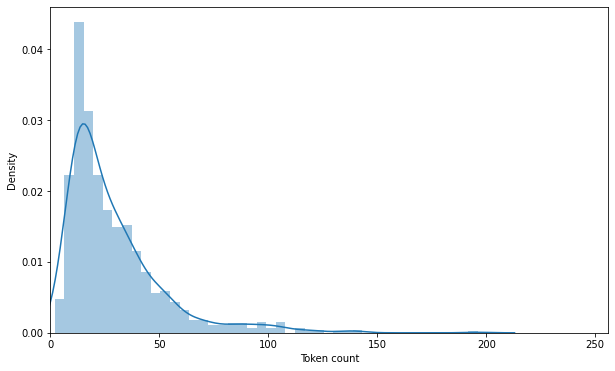

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);  #max lenght of the sequence
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 120

In [ ]:
class SwahiliAbusiveLanguageDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text = preprocess_text(text),
      add_special_tokens=True, # Add `[CLS]` and `[SEP]`
      max_length=self.max_len, # Define maximum sequence length
      truncation=True,         # Truncate on maximum seq length
      return_token_type_ids=False,  
      pad_to_max_length=True,  # Pad seq to Max length
      return_attention_mask=True,  # Return attenstion mask
      return_tensors='pt',    # Return pytorch tensor
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Utility function to create an iterator for our dataset
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SwahiliAbusiveLanguageDataset(text=df.tweet.to_numpy(), targets=df['class'].to_numpy(),tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [ ]:
BATCH_SIZE = 16
# Create dataloaders to help with saving memory and increasing training speed
# Dataloader for training set
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

# Dataloader for validation set
valid_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)

# Dataloader for test set
test_data_loader  = create_data_loader(df_test,  tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Load pre-trained BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SwahiliAbusiveLanguageClassifier(nn.Module):
  """
    Args:
      n_classes (int): Number of classes in the dataset
  """
  def __init__(self, n_classes=2, drop=0.35):
    super(SwahiliAbusiveLanguageClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=drop)  # Droupout Layer of Classifier
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # Linear Layer of classifier

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.drop(pooled_output)  # Pass transformer output to Droupout Layer
    return self.out(output)

In [ ]:
model = SwahiliAbusiveLanguageClassifier()
model = model.to(device)

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  # Set model into train mode
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    # model forward pass to return logits
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    # calculate loss on the logits
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    # model backward pass to calculate gradients
    loss.backward()
    # clip gradient norm to 1.0 to avoid eploding gradient problem
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # update model parameters
    optimizer.step()
    # update learning rate
    scheduler.step()
    # zero out previously calculated gradient
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  # Set model into evaluation mode
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      # get model predictions
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
  
  valid_acc, valid_loss = eval_model(model, valid_data_loader, loss_fn, device, len(df_valid))
  print(f'Valid loss {valid_loss:.4f} accuracy {valid_acc:.4f}')
  print()
  # accumulate train and validation loss and accuracy to vialualize model peformance
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['valid_acc'].append(valid_acc)
  history['valid_loss'].append(valid_loss)
  if valid_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = valid_acc

Epoch 1/5
----------
Train loss 0.7096 accuracy 0.5069
Valid loss 0.6589 accuracy 0.6167

Epoch 2/5
----------
Train loss 0.6389 accuracy 0.6433
Valid loss 0.6359 accuracy 0.6500

Epoch 3/5
----------
Train loss 0.4848 accuracy 0.7760
Valid loss 0.7178 accuracy 0.6333

Epoch 4/5
----------
Train loss 0.3315 accuracy 0.8586
Valid loss 0.8045 accuracy 0.6833

Epoch 5/5
----------
Train loss 0.2233 accuracy 0.9086
Valid loss 0.9837 accuracy 0.6750

CPU times: user 59.8 s, sys: 36.9 s, total: 1min 36s
Wall time: 1min 39s


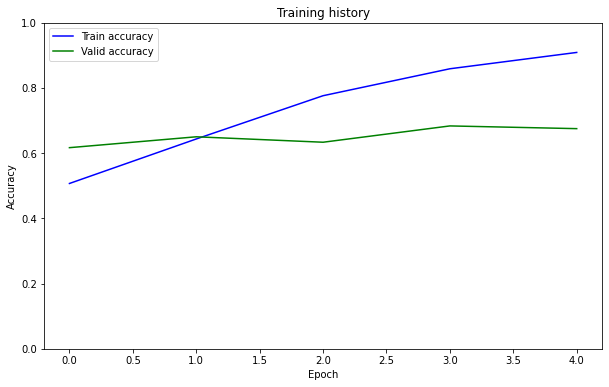

In [ ]:
plt.plot(history['train_acc'], color='blue', label='Train accuracy')
plt.plot(history['valid_acc'], color='green', label='Valid accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

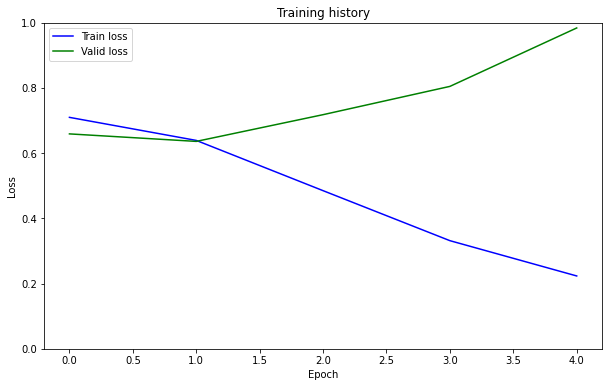

In [ ]:
plt.plot(history['train_loss'], color='blue', label='Train loss')
plt.plot(history['valid_loss'], color='green', label='Valid loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
train_acc, _ = eval_model(model, train_data_loader, loss_fn, device, len(df_train))
print(f'Train accuracy: {train_acc.item():.3f}')

Train accuracy: 0.951


In [ ]:
valid_acc, _ = eval_model(model, valid_data_loader, loss_fn, device, len(df_valid))
print(f'Validation accuracy: {valid_acc.item():.3f}')

Validation accuracy: 0.675


In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test accuracy: {test_acc.item():.3f}')

Test accuracy: 0.725


In [ ]:
# utility function for evaluating model perfomance
def get_predictions(model, data_loader):
  model = model.eval()
  text = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return text, predictions, prediction_probs, real_values

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69        35
           1       0.77      0.73      0.75        45

    accuracy                           0.73        80
   macro avg       0.72      0.72      0.72        80
weighted avg       0.73      0.72      0.73        80




TN: 0.7142857142857143
FP: 0.2857142857142857
FN: 0.26666666666666666
TP: 0.7333333333333333



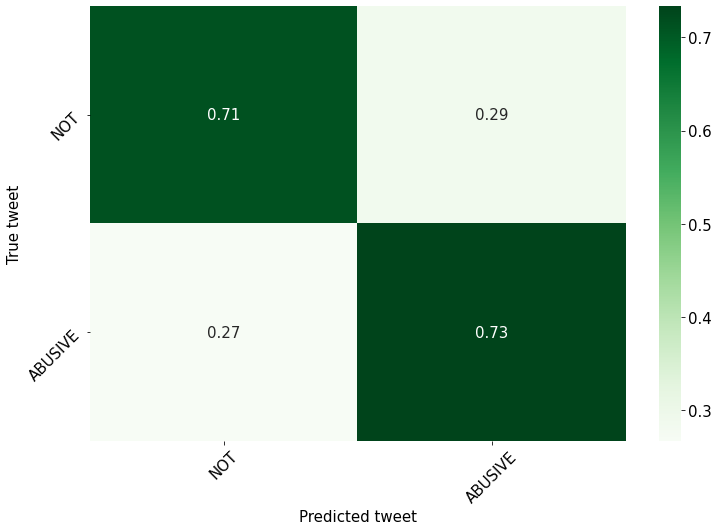

In [ ]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["font.size"] = (15)

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Greens")
  hmap.yaxis.set_ticklabels(classes, rotation='45')
  hmap.xaxis.set_ticklabels(classes, rotation='45')
  plt.ylabel('True tweet')
  plt.xlabel('Predicted tweet');

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm)

tn, fp, fn, tp = cm.ravel()
print(f"""
TN: {tn}
FP: {fp}
FN: {fn}
TP: {tp}
""")
show_confusion_matrix(df_cm)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)

print(f'''BERT
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

BERT
Accuracy: 0.72
f1_score: 0.75


In [ ]:
bert = {'model': 'BERT', 'accuracy': 0.72, 'f1_score': 0.76}
bert

{'accuracy': 0.72, 'f1_score': 0.76, 'model': 'BERT'}

In [ ]:
x_train, y_train = df_train.tweet.values, df_train['class'].values.astype('int')
x_valid, y_valid = df_valid.tweet.values, df_valid['class'].values.astype('int')
x_test, y_test = df_test.tweet.values, df_test['class'].values.astype('int')

In [ ]:
tf_idf = TfidfVectorizer(max_features=150) #max features a TFIDF can take 
x_train = np.r_[x_train, x_valid]
y_train = np.r_[y_train, y_valid]
x_train_tfidf = tf_idf.fit_transform(x_train).toarray()
x_test_tfidf  = tf_idf.fit_transform(x_test).toarray()

In [ ]:
tf_idf.vocabulary_.items()

dict_items([('hiyo', 19), ('harufu', 15), ('na', 55), ('wanaume', 140), ('hao', 13), ('ndo', 73), ('miguu', 45), ('kwenye', 36), ('ubunge', 129), ('hizo', 21), ('nafasi', 56), ('tatizo', 110), ('sana', 87), ('au', 5), ('ni', 78), ('wako', 138), ('wa', 136), ('ila', 24), ('tu', 116), ('nani', 62), ('ananuka', 3), ('url', 134), ('we', 141), ('hakuna', 12), ('ww', 143), ('acha', 0), ('sis', 97), ('tunawajua', 124), ('diva', 11), ('nafikiri', 57), ('swali', 105), ('nao', 63), ('hata', 16), ('tweeter', 128), ('so', 100), ('rudi', 84), ('tena', 113), ('wewe', 142), ('tayari', 112), ('dada', 10), ('mbona', 42), ('unanuka', 131), ('za', 149), ('kila', 29), ('mwezi', 53), ('sisi', 98), ('kama', 27), ('cha', 9), ('kima', 30), ('kuwa', 34), ('naweza', 71), ('hili', 17), ('suala', 102), ('mtu', 47), ('ndio', 72), ('ungekuwa', 132), ('then', 114), ('mbali', 41), ('nenda', 75), ('kanye', 28), ('si', 93), ('wanaonuka', 139), ('jasho', 25), ('kwa', 35), ('me', 43), ('namuua', 61), ('hivyo', 18), ('sik

In [ ]:
idf = tf_idf.idf_
print(dict(zip(tf_idf.get_feature_names(), idf)))

{'acha': 4.008154793552548, 'afu': 4.295836866004329, 'ajira': 3.785011242238338, 'ananuka': 4.295836866004329, 'anataka': 4.295836866004329, 'au': 3.785011242238338, 'baba': 4.295836866004329, 'bandia': 4.701301974112493, 'bwege': 4.295836866004329, 'cha': 4.008154793552548, 'dada': 3.785011242238338, 'diva': 4.008154793552548, 'hakuna': 4.295836866004329, 'hao': 4.295836866004329, 'hapa': 4.295836866004329, 'harufu': 4.008154793552548, 'hata': 4.008154793552548, 'hili': 4.295836866004329, 'hivyo': 4.295836866004329, 'hiyo': 4.295836866004329, 'hizi': 4.295836866004329, 'hizo': 4.008154793552548, 'huo': 4.295836866004329, 'huyu': 3.6026896854443837, 'ila': 4.008154793552548, 'jasho': 4.008154793552548, 'kabisa': 3.785011242238338, 'kama': 3.785011242238338, 'kanye': 4.295836866004329, 'kila': 4.295836866004329, 'kima': 4.295836866004329, 'kuchimba': 4.701301974112493, 'kuma': 4.008154793552548, 'kuna': 4.295836866004329, 'kuwa': 4.008154793552548, 'kwa': 3.6026896854443837, 'kwenye': 

In [ ]:
d = dict(zip(tf_idf.get_feature_names(), idf))
token_weight = pd.DataFrame.from_dict(d, orient='index').reset_index()
token_weight.columns=('token','weight')
# sort token weights in ascending order
token_weight = token_weight.sort_values(by='weight', ascending=True).head(20)

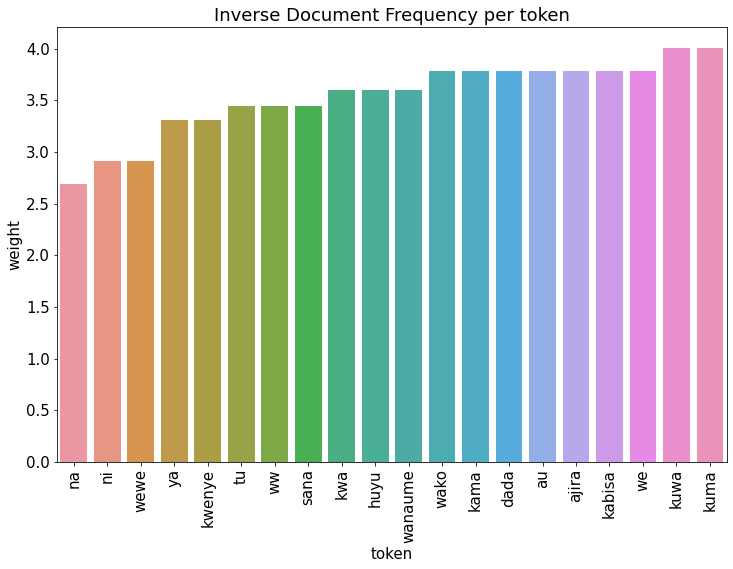

In [ ]:
sns.barplot(x='token', y='weight', data=token_weight)            
plt.title("Inverse Document Frequency per token")
plt.xticks(rotation=90)
plt.show()

In [ ]:
token_weight

,token,weight
55,na,2.686399
78,ni,2.909543
142,wewe,2.909543
144,ya,3.315008
36,kwenye,3.315008
116,tu,3.448539
143,ww,3.448539
87,sana,3.448539
35,kwa,3.602690
23,huyu,3.602690


In [ ]:
stopwords = ['na', 'ya', 'ni', 'au', 'wewe']

In [ ]:
df_train_tdif = pd.DataFrame(x_train_tfidf[0].T, index=tf_idf.get_feature_names(), columns=["tfidf"])
df_train_tdif.sort_values(by=["tfidf"], ascending=False).head(10)

,tfidf
ila,0.774329
tunaokuweka,0.632783
acha,0.000000
sis,0.000000
sisi,0.000000
siyo,0.000000
so,0.000000
ss,0.000000
suala,0.000000
supposed,0.000000
